<a href="https://colab.research.google.com/github/ryojun/FoodClassification/blob/master/sushi_sundays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
# from scipy.misc import imresize
# from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
import cv2

In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [ ]:
root_position = "/content/drive/MyDrive/Colab Notebooks/Thesis/FoodsRank/sushi_sundays/rank/testTwo/"

In [ ]:
# picking 3 food items and generating separate data folders for the same
food_list = ['Best','Worst']
src_train = root_position+'train'
# dest_train = root_position+'burger/burger/train_mini'
src_test = root_position+'test'
# dest_test = root_position+'burger/burger/test_mini'

In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk(src_train)])
print(train_files)

Total number of samples in train folder
233


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk(src_test)])
print(test_files)

Total number of samples in test folder
233


In [ ]:
!nvidia-smi

Wed Apr 21 05:47:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = src_train
  validation_data_dir = src_test
  batch_size = 16
  bestmodel_path = root_position+'weights-improvement-{epoch:02d}-{val_accuracy:.2f} bestmodel_2class.hdf5'
  trainedmodel_path = root_position+'weights-improvement-{epoch:02d}-{val_accuracy:.2f} trainedmodel_2class.hdf5'
  history_path = root_position+'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [ ]:
# Train the model with data from 3 classes
n_classes = 2
epochs = 300
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 233 images belonging to 2 classes.
Found 233 images belonging to 2 classes.
87916544/87910968 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300
14/14 [==============================] - 315s 22s/step - loss: 0.7378 - accuracy: 0.5226 - val_loss: 0.7732 - val_accuracy: 0.5848

Epoch 00001: val_accuracy improved from -inf to 0.58482, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/FoodsRank/sushi_sundays/rank/testTwo/weights-improvement-01-0.58 bestmodel_2class.hdf5
Epoch 2/300
14/14 [==============================] - 15s 1s/step - loss: 0.6898 - accuracy: 0.5723 - val_loss: 0.7544 - val_accuracy: 0.5938

Epoch 00002: val_accuracy improved from 0.58482 to 0.59375, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/FoodsRank/sushi_sundays/rank/testTwo/weights-improvement-02-0.59 bestmodel_2class.hdf5
Epoch 3/300
14/14 [==============================] - 16s 1s/step - loss: 0.6950 - accuracy: 0.6169 - val_loss: 0.7587 - val_accuracy: 0.5893

Epoch 00003: val_accuracy did not improve from 0.59375
Epoch 4/300
14/14 [==============================] - 15s 1s/step - loss: 0.6875 - accuracy: 0.5939 - v

In [ ]:
K.clear_session()
model_best = load_model('/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/trainedmodel_2class.hdf5',compile = False)

In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Make a list of images and test the trained model
images = []
imagepath = root_position+'food-101/try/'
images.append(imagepath+'ramen.jpg')
images.append(imagepath+'pizza.jpg')
images.append(imagepath+'pizza2.jpg')
images.append(imagepath+'sushi.jpg')
images.append(imagepath+'sushi2.jpg')
images.append(imagepath+'sushi3.jpg')
images.append(imagepath+'sushi4.jpg')
predict_class(model_best, images, True)

NameError: ignored

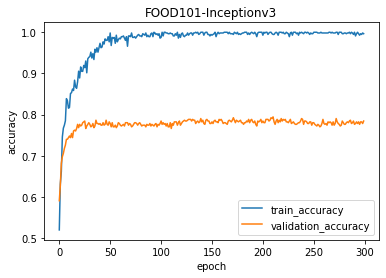

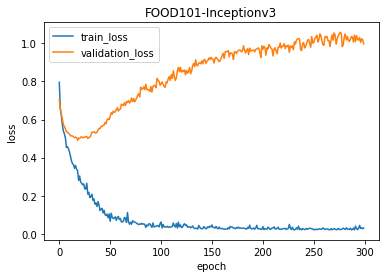

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [ ]:
def train_model_Next(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = root_position+'foods-IG/sushi/train'
  validation_data_dir = root_position+'foods-IG/sushi/test'
  batch_size = 16
  bestmodel_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/Newbestmodel_2class.hdf5'
  trainedmodel_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/trainedmodel_2class.hdf5'
  history_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/history_2.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  # inception = InceptionV3(weights='imagenet', include_top=False)
  # x = inception.output
  # x = GlobalAveragePooling2D()(x)
  # x = Dense(128,activation='relu')(x)
  # x = Dropout(0.2)(x)

  # predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = load_model('/content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/bestmodel_2class.hdf5')
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  # model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [ ]:
# Train the model with data from 3 classes
n_classes = 2
epochs = 10
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_3 = train_model_Next(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 1149 images belonging to 2 classes.
Found 930 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
71/71 [==============================] - 1300s 18s/step - loss: 0.1782 - accuracy: 0.9437 - val_loss: 0.1480 - val_accuracy: 0.9547

Epoch 00001: val_accuracy improved from -inf to 0.95474, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/Newbestmodel_2class.hdf5
Epoch 2/10
71/71 [==============================] - 1218s 17s/step - loss: 0.1912 - accuracy: 0.9306 - val_loss: 0.1386 - val_accuracy: 0.9612

Epoch 00002: val_accuracy improved from 0.95474 to 0.96121, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/foodsClassification/Newbestmodel_2class.hdf5
Epoch 3/10
71/71 [==============================] - 1225s 17s/step - loss: 0.1455 - accuracy: 0.9638 - val_loss: 0.1399 - val_accuracy: 0.9547

Epoch 00003: val_accuracy did not improve from 0.96121
Epoch 4/10
71/71 [==============================] - 1227s 17s/step - loss: 0.1357 - accuracy: 0.9663 - val_loss: 0.1282 - val_accuracy: 0.9612

Epoch 00004: val_accuracy did not impr